In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

PATH = Path('data')
list(PATH.iterdir())

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_feather(PATH/'houston_ready.feather')

In [4]:
df.head(3).T
df.shape

,0,1,2
accuracy,30,21,1259
altitude,0,0,0
heading,NaN,NaN,NaN
velocity,NaN,NaN,NaN
verticalAccuracy,NaN,NaN,NaN
act_conf1,46,NaN,100
act_type1,UNKNOWN,None,TILTING
act_cont2,27,NaN,NaN
act_type2,IN_VEHICLE,None,None
extra_intVal,NaN,NaN,NaN


(341045, 21)

# Clustering and plotting cluster

In [62]:
from sklearn.cluster import KMeans
k=5

In [63]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='tab10').to_rgba
num_colr = k
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [7]:

kmeans = KMeans(n_clusters=k,random_state=42).fit(df[['latitude','longitude']])
df['cluster']= kmeans.predict(df[['latitude','longitude']])

In [56]:
num_colr = k
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

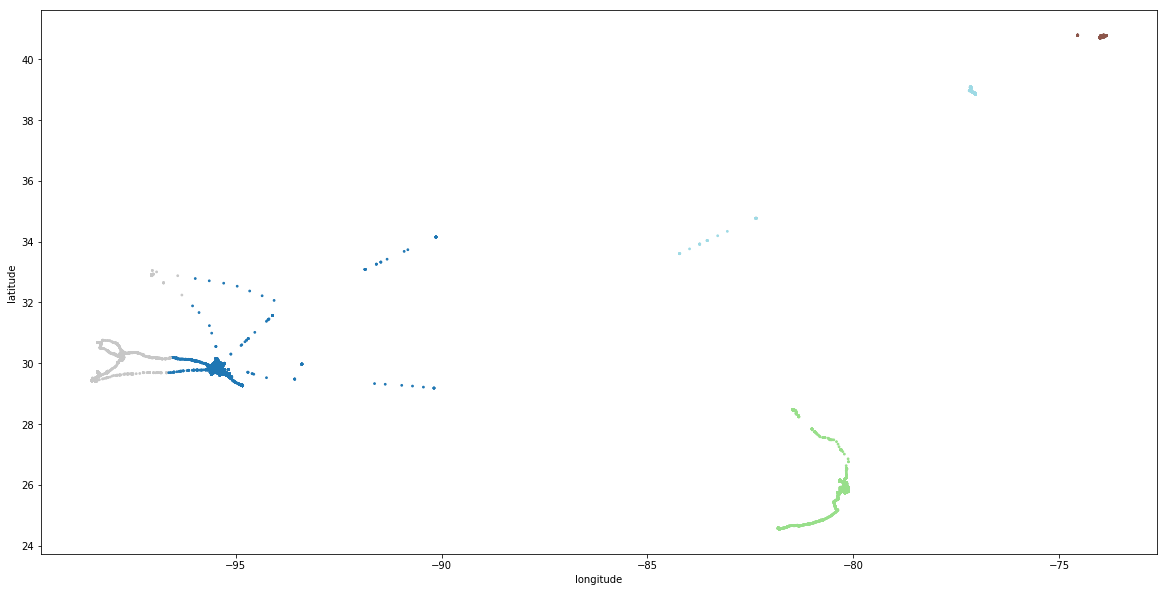

In [58]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df.longitude,df.latitude,c=df.cluster,cmap='tab20',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


Let's try to exclude plane and/or state travel GPS points

In [8]:
# recalculate miles differences
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

km_diff = haversine_array(lat1,long1,lat2,long2) 
df['mile_diff'] = km_diff * 0.621371 # to miles

In [51]:
df[df.mile_diff>13].groupby(['year','month','day']).latitude.count()

year  month  day
2016  4      18      2
      5      31      9
      6      3       2
      10     13     10
      12     21     16
             22      1
             24      1
             26      8
             29     10
2017  1      3       1
Name: latitude, dtype: int64

In [39]:
df['plane'] = df.mile_diff>13

In [41]:
# df.to_feather(PATH/'houston_ready.feather')

In [46]:
df_ground = df[~df.plane].copy().reset_index(drop=True)

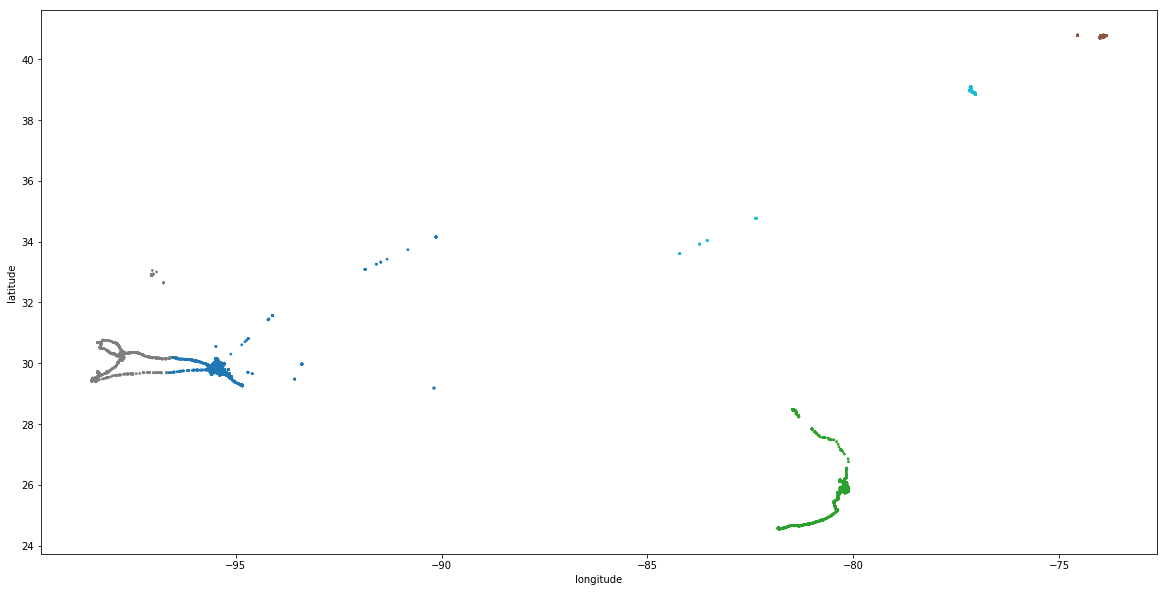

In [58]:
k=5
kmeans = KMeans(n_clusters=k,random_state=42).fit(df_ground[['latitude','longitude']])
df_ground['cluster']= kmeans.predict(df_ground[['latitude','longitude']])

fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_ground.longitude,df_ground.latitude,c=df_ground.cluster,cmap='tab10',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


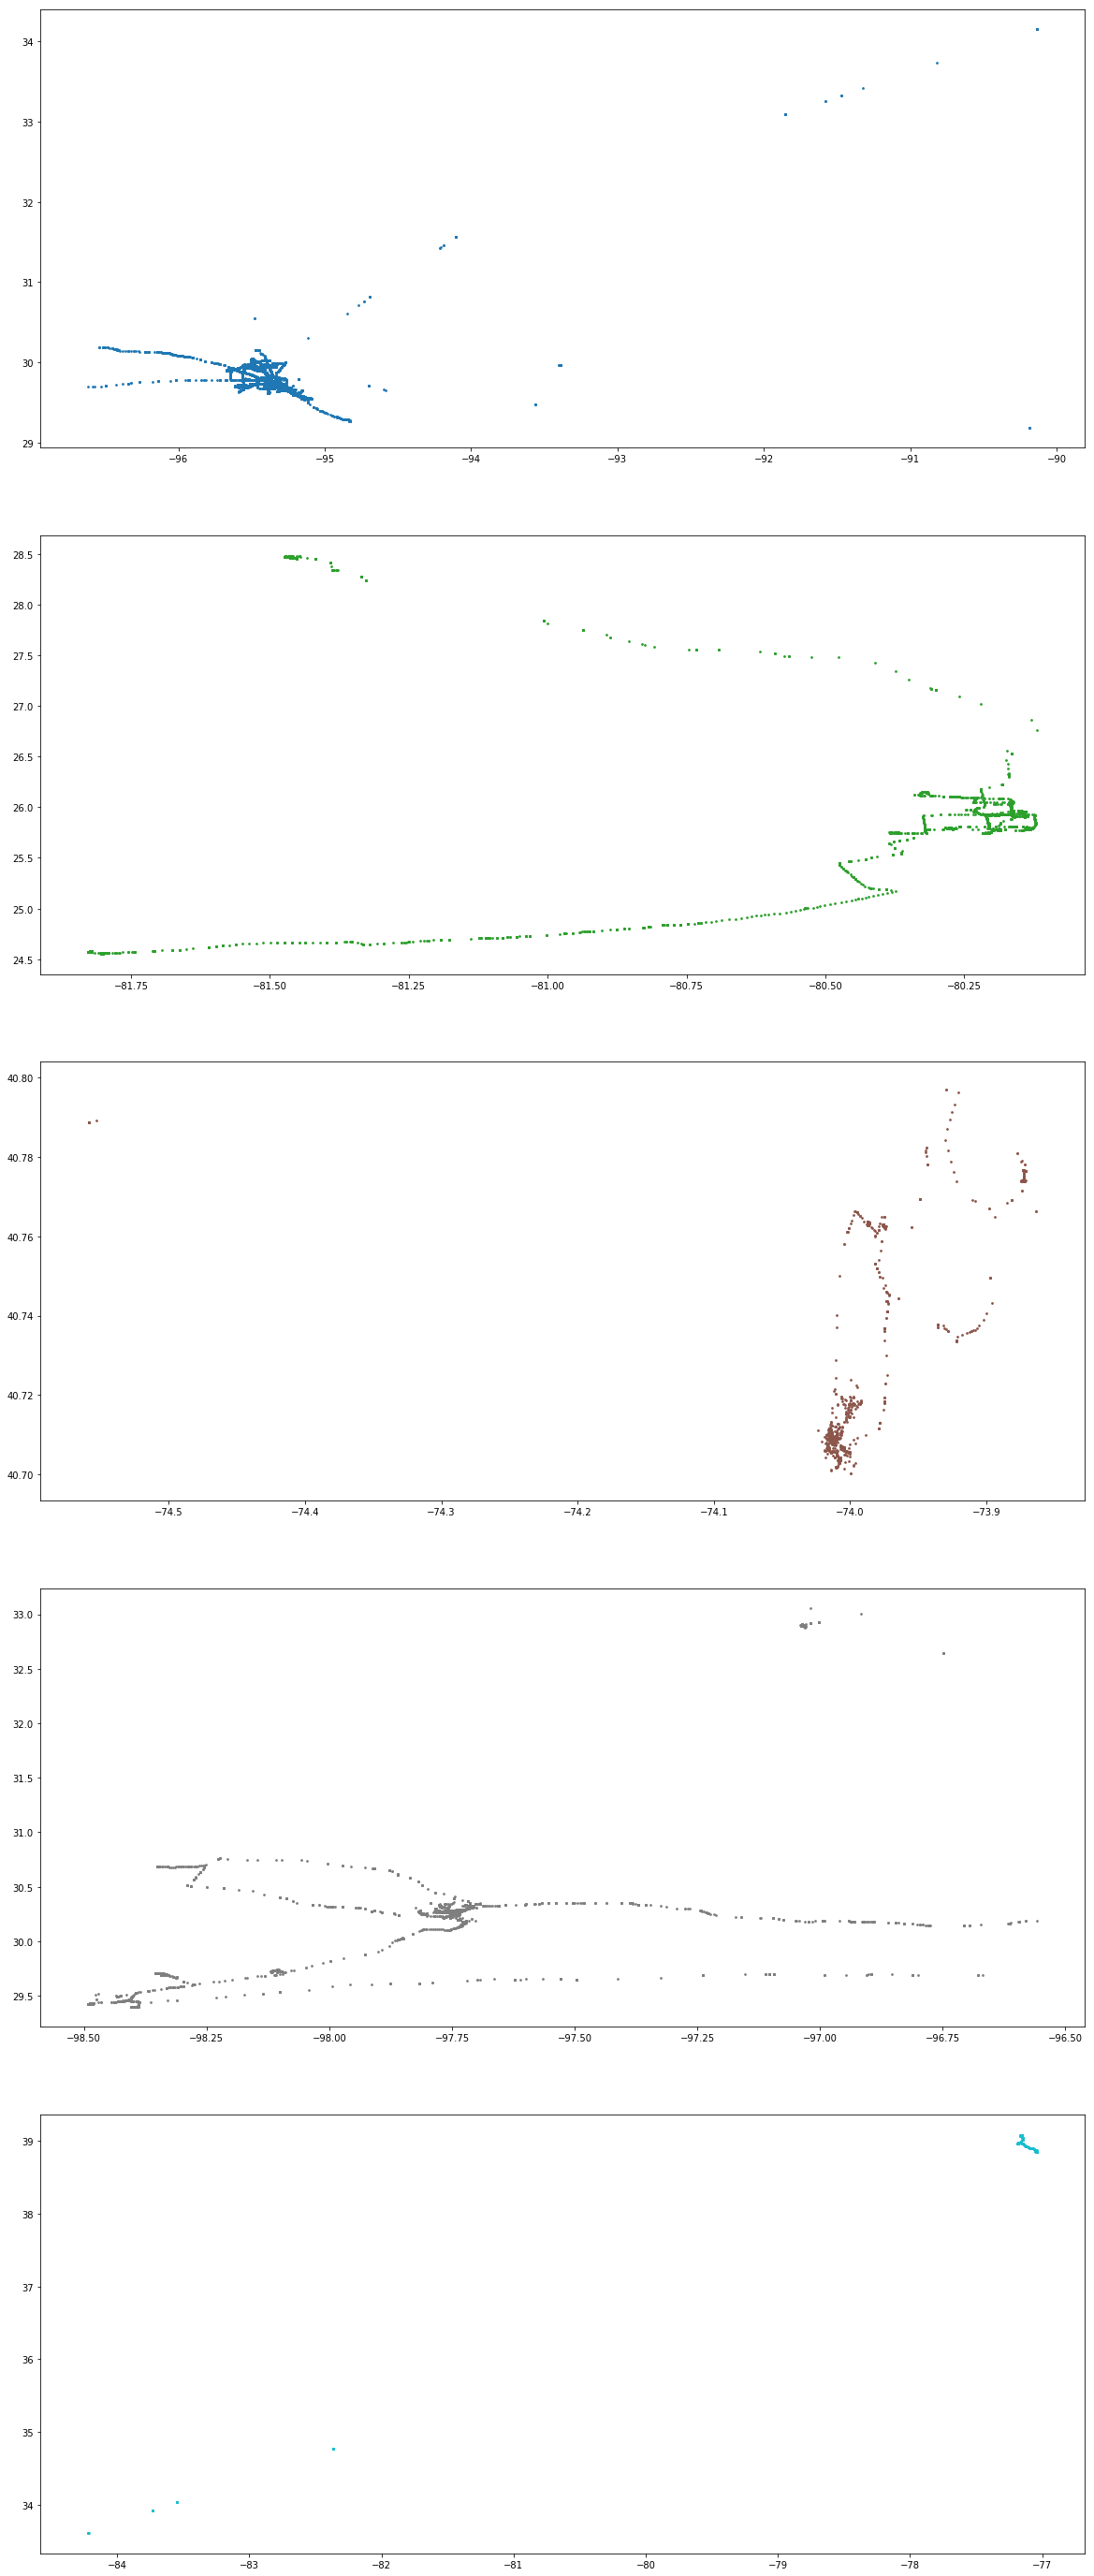

In [64]:
fig,axes = plt.subplots(nrows=k,figsize=(20,10*k));
for i in range(k):
    _=axes[i].scatter(df_ground[df_ground.cluster==i].longitude,df_ground[df_ground.cluster==i].latitude, c=colr_list[i],s=3,alpha=1)


After few k, k=5 seems to fit best as kmeans recognizes all the major states. Let's take a look at few of them

In [ ]:
# cluster 1: FLorida
df_flo = df[df]

# TODO: identify weekday and weekend point

# TODO: identify 'home' and 'work' cluster

# TODO: identify 'vacation' and other clusters